## Data analysis

In this notebook, we performe a basic data analysis of our data, including some graph vizualizations.  

In [2]:
import pandas as pd
import re

In [3]:
data_dir = '../data/'

#### How much are phytochemicals in drugs?

In [21]:
drug_ingredients = pd.read_csv(data_dir + 'drugbank/drug_id_name_map.csv', index_col=[0])

with open(data_dir + 'phytochemicals.txt', 'r') as f:
    lines = f.readlines()  

phytochemicals = [re.sub('\n', '', x) for x in lines]   
phytochemicals = [x.lower() for x in phytochemicals] 

print(phytochemicals[:10])
phytochemicals = set(phytochemicals)

['phytoene', 'zeaxanthin', 'lentinan', 'farnesyl pyrophosphate', 'pentose', 'carotene, gamma', 'theogallin', 'pectin', 'cembrene', 'pimaric acid']


In [6]:
drug_names = set(drug_ingredients.drug_name)

drugs_with_phytochemicals = dict()
phytochemicals_in_drugs = set()

phytochemicals = list(phytochemicals)

for drug_name in drug_names:
    ingredient = drug_name.lower()

    if ingredient in phytochemicals:
        drugs_with_phytochemicals[drug_name] = phytochemicals.index(ingredient)
        phytochemicals_in_drugs.add(ingredient)


print(phytochemicals_in_drugs)
print()
print('Number of drugs that contains phytochemicals:', len(drugs_with_phytochemicals), '/ out of', len(drug_names))

{'tannic acid', 'capsaicin', 'phenol', 'betulinic acid', 'tyrosine', 'thymol', 'lycopene', 'beta carotene', 'paclitaxel', 'camphor', 'hesperidin', 'phenylalanine', 'lutein', 'cholecalciferol', 'pectin', 'geraniol', 'cholesterol', 'inulin', 'menthol', 'tocopherol', 'tryptophan', 'salicylic acid', 'curcumin', 'zeaxanthin', 'testosterone', 'rutin'}

Number of drugs that contains phytochemicals: 26 / out of 4225


### Data Analysis
(in training dataset)

#### Drugs

In [64]:
drug_subclass = pd.read_csv(data_dir + 'triplets/drug_subclass.tsv', sep='\t', index_col=[0])
print(drug_subclass.head(3))
print()

drug_salts = pd.read_csv(data_dir + 'triplets/drug_salts.tsv', sep='\t', index_col=[0])
print(drug_salts.head(3))
print()

drug_ingredients = pd.read_csv(data_dir + 'triplets/ingredients.tsv', sep='\t', index_col=[0])
print(drug_ingredients.head(3))
print()

drug_interactions = pd.read_csv(data_dir + 'triplets/ddi.tsv', sep='\t', index_col=[0])
print(drug_interactions.head(3))
print()

        id     relation subclass
1  DB00001  in_subclass  class_0
2  DB00002  in_subclass  class_0
3  DB00003  in_subclass  class_0

      drug  relation       salt_id
1  DB00007  contains  DBSALT000105
2  DB00007  contains  DBSALT003182
3  DB00010  contains  DBSALT001439

   drug_name  relation ingredient
0   refludan  contains    DB00001
1    erbitux  contains    DB00002
2  pulmozyme  contains    DB00003

     drug1                        interaction    drug2
0  DB06605  increase_anticoagulant_activities  DB00001
1  DB06695  increase_anticoagulant_activities  DB00001
2  DB01254                  increase_bleeding  DB00001



#### Food

In [8]:
food_compounds = pd.read_csv(data_dir + 'triplets/food_compound.tsv', sep='\t', index_col=[0])
print(food_compounds.head())
print()

compounds_cas_num = pd.read_csv(data_dir + 'triplets/compounds_cas_number.tsv', sep='\t', index_col=[0])
print(compounds_cas_num.head())
print()

     food_id  relation compound_id
0  FOOD00001  contains   FDB013255
1  FOOD00001  contains   FDB011904
2  FOOD00002  contains   FDB014613
3  FOOD00002  contains   FDB008322
4  FOOD00002  contains   FDB000474

  compound_id        relation cas_number
0   FDB015503  has_cas_number   469-38-5
1   FDB002558  has_cas_number   331-39-5
2   FDB000474  has_cas_number    56-87-1
3   FDB002251  has_cas_number    54-12-6
4   FDB000633  has_cas_number   520-18-3



## Graph visualization

In [9]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import torch_geometric.transforms as T
from torch_geometric.data import Data
import networkx as nx
from networkx.algorithms import community
from ogb.linkproppred import Evaluator, PygLinkPropPredDataset
import random
import itertools
from operator import itemgetter

In [10]:
!pip3 install pyvis

In [11]:
from pyvis.network import Network

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
def visuzlize_graph(data):
    G = to_networkx(data, to_undirected=False)
    pos = nx.spring_layout(G, seed=42)
    cent = nx.degree_centrality(G)
    node_size = list(map(lambda x: x * 800, cent.values()))
    cent_array = np.array(list(cent.values()))
    threshold = sorted(cent_array, reverse=True)[10]
    print("threshold", threshold)
    cent_bin = np.where(cent_array >= threshold, 1, 0.1)
    plt.figure(figsize=(12, 12))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                   cmap=plt.cm.viridis,
                                   node_color=cent_bin,
                                   nodelist=list(cent.keys()),
                                   alpha=cent_bin)
    labels = nx.draw_networkx_labels(G, pos=nx.spring_layout(G))
    edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.6)
    plt.show()

### DrugBank data

In [32]:
my_data = 'triplets/run1/train_drugbank.tsv'
data_df = pd.read_csv(data_dir + my_data, sep='\t')
data_df = data_df.dropna()

In [33]:
nodes = data_df[['head', 'tail']].stack().unique()
print('Number of unique nodes:', len(nodes))
nodes_map = {node: i for i, node in enumerate(nodes)}

edges = data_df['relation'].unique()
edges_map = {edge: i for i, edge in enumerate(edges)}
print('Number of unique edges:', len(edges))

Number of unique nodes: 19922
Number of unique edges: 7


In [34]:
heads = data_df['head'].map(nodes_map)
tails = data_df['tail'].map(nodes_map)

In [35]:
edges = torch.tensor([heads.values, tails.values])

/tmp/ipykernel_15/1872461729.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edges = torch.tensor([heads.values, tails.values])


In [36]:
IDX = 'DB00008'
node_id = nodes_map[IDX]

In [37]:
def random_sample(G, k=100):
    sampled_nodes = random.sample(G.nodes, k)
    return G.subgraph(sampled_nodes)
    

data_graph = Data(edge_index=edges, num_nodes=len(nodes))
G = to_networkx(data_graph, to_undirected=False)
G_subgraph = random_sample(G)

In [38]:
def particular_sample(nodes_idx, edge_index):
    mask = torch.from_numpy(np.isin(edge_index, nodes_idx).sum(axis=0) > 0)
    mask = mask.expand(2,-1)

    # select just edges with generated node index (nodes_idx)
    edge_index_sample = edge_index * mask 

    # get rid of 0s columns
    non_empty_mask = edge_index_sample.sum(dim=0).bool()
    edge_index_sample = edge_index_sample[:,non_empty_mask]
    
    return edge_index_sample

In [39]:
# edges_sample = random_sample(edges, len(nodes), k=5)
edges_sample = particular_sample([node_id], edges)
print(edges_sample)
num_nodes = edges_sample.unique()
print('number of unique nodes:', num_nodes.size(0))
data_sample = Data(edge_index=edges_sample, num_nodes=num_nodes.size(0))
# visuzlize_graph(data_sample)

tensor([[ 1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,  1967,
          1967,  1967,  1967,  1967,  1967,  1967,  

## Analyze the training data (graph)

- number of drug-drug or drug-food realtions in training data 
- node degree
- number of node types
- number of edges
- connections of enzymes/pathways to drugs

In [40]:
# number of drug-drug or drug-food realtions in training data

data_df['node_type'] = list(itertools.repeat('xxx', data_df.shape[0]))
data_df.loc[data_df['tail'].str.contains("DB\d+", regex=True), 'node_type'] = "drug"
data_df.loc[data_df['tail'].str.contains("FOOD"), 'node_type'] = "food"
data_df = data_df.loc[data_df['node_type'] != 'xxx']
data_df

head   relation       tail node_type
0         DB06590  interacts    DB00303      drug
1         DB03619  interacts    DB00455      drug
2         DB01142  interacts    DB00967      drug
3         DB00877  interacts    DB00078      drug
4         DB01270  interacts    DB00056      drug
...           ...        ...        ...       ...
656817  FOOD00991   contains  FDB012535      drug
656818  FOOD00991   contains  FDB000484      drug
656819  FOOD00992   contains  FDB012160      drug
656820  FOOD00992   contains  FDB001014      drug
656821  FOOD00992   contains  FDB008322      drug

[560226 rows x 4 columns]

In [41]:
dd_interactions_count = data_df[(data_df['node_type'] == 'drug') & (data_df['head'].str.match(r'DB\d+'))].shape[0]
df_interactions_count = data_df[(data_df['node_type'] == 'food') & (data_df['head'].str.match(r'DB\d+'))].shape[0]

print(f'Number of drug-drug relations in training data: {dd_interactions_count}')
print(f'Number of drug-food relations in training data: {df_interactions_count}')

Number of drug-drug relations in training data: 546490
Number of drug-food relations in training data: 762


count   mean     std  min  25%  50%   75%     max
0  19922.0  67.65  192.53  1.0  2.0  5.0  15.0  1634.0

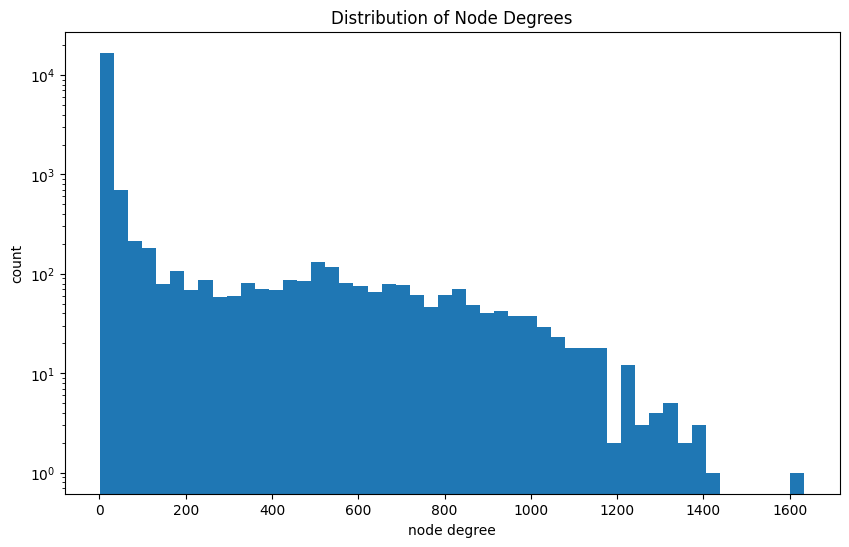

In [42]:
data = Data(edge_index=edges, num_nodes=len(nodes))

G = to_networkx(data, to_undirected=False)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
# print(len(degrees))
# print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.ylabel("count")
plt.yscale('log')
plt.title('Distribution of Node Degrees')
plt.show()

In [43]:
# node type distribution

# DB... - drug
# FOOD... - food
# FDB... - food compound
# cas number
# DBSALT... - drug salt
# subclass
# protein_...
# sideeffect_...
# disease_...
# SMP... - pathway
# pathway category 
# P/Q... - enzyme

# 12 types of nodes
nodes_list = data_df[['head', 'tail']].stack().unique()
nodes_df = pd.DataFrame({'node_id': nodes_list})

# it may be incorrect in some cases ??
nodes_df['node_type'] = list(itertools.repeat('cas_num', nodes_df.shape[0]))
nodes_df.loc[nodes_df['node_id'].str.contains("DB"), 'node_type'] = "drug"
nodes_df.loc[nodes_df['node_id'].str.contains("FOOD"), 'node_type'] = "food"
nodes_df.loc[nodes_df['node_id'].str.contains("FDB"), 'node_type'] = "food_compound"
nodes_df.loc[nodes_df['node_id'].str.contains("DBSALT"), 'node_type'] = "salt"
nodes_df.loc[nodes_df['node_id'].str.contains("class"), 'node_type'] = "drug_class"
nodes_df.loc[nodes_df['node_id'].str.contains("protein"), 'node_type'] = "protein"
nodes_df.loc[nodes_df['node_id'].str.contains("sideeffect"), 'node_type'] = "side_effect"
nodes_df.loc[nodes_df['node_id'].str.contains("disease"), 'node_type'] = "disease"
nodes_df.loc[nodes_df['node_id'].str.contains("SMP"), 'node_type'] = "pathway"
nodes_df.loc[nodes_df['node_id'].str.contains("pathway_cat"), 'node_type'] = "pathway_category"
nodes_df.loc[nodes_df['node_id'].str.contains("^[OPQ]\d+", regex=True), 'node_type'] = "enzyme"

nodes_df_grouped = nodes_df.groupby(by=['node_type']).count()
nodes_df_grouped.columns = ['count']
nodes_df_grouped = nodes_df_grouped.sort_values(by='count', ascending=False)
nodes_df_grouped

count
node_type           
drug            2551
food             791
pathway          758
food_compound    165

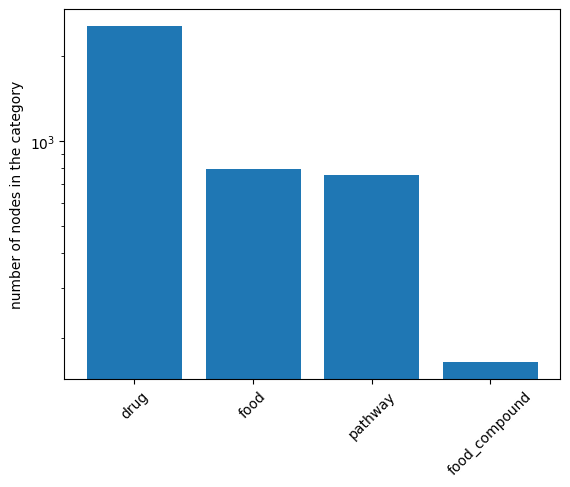

In [44]:
counts = nodes_df_grouped['count'].values
node_types = nodes_df_grouped.index

plt.bar(node_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of nodes in the category')
plt.show()

In [45]:
# edge type distribution
edge_types_grouped = data_df.groupby(by=['relation']).count()
edge_types_grouped = edge_types_grouped.drop(columns=['tail', 'node_type'])
edge_types_grouped

head
relation                   
contains              11017
interacts            547252
involved_in_pathway    1957

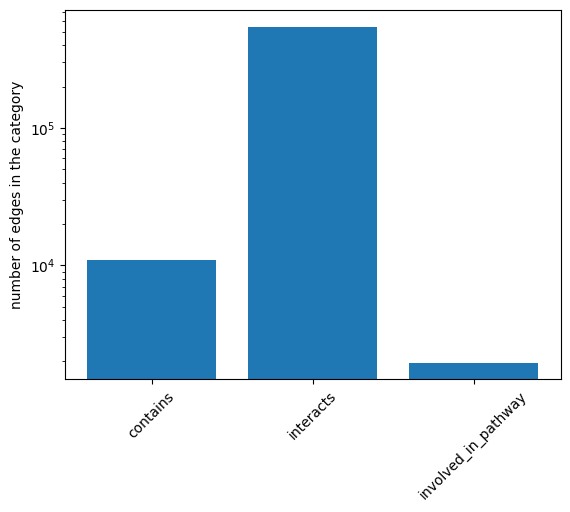

In [46]:
counts = list(edge_types_grouped['head'].values)
edge_types = list(edge_types_grouped.index)

plt.bar(edge_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of edges in the category')
plt.show()

In [47]:
# vizualiztion for a specific drug(s)

Following code from https://github.com/kennethleungty/Drug-Interactions-Network-Analysis-and-Visualization/blob/main/02_Network_Analysis_and_Visualization.ipynb

In [48]:
# Generate a networkx graph
G = nx.from_pandas_edgelist(data_df, 'head', 'tail')

# Give the graph a name
G.name = 'Drug Interactions Network'

# Check whether graph is directed or undirected (False = undirected)
print(G.is_directed())

# Obtain general information of graph
# print(nx.info(G))

# Get graph density
density = nx.density(G)
print("Network density:", density)

False
Network density: 0.06161082505405269


In [49]:
drug_ingredients

id                                          drug_name
1     DB00001                                          Lepirudin
2     DB00002                                          Cetuximab
3     DB00003                                       Dornase alfa
4     DB00004                                Denileukin diftitox
5     DB00005                                         Etanercept
...       ...                                                ...
4221  DB16727  Influenza A virus A/Washington/19/2020 (H1N1) ...
4222  DB16732                                  Tisotumab vedotin
4223  DB16736                 Allogeneic processed thymus tissue
4224  DB16741                              Bortezomib D-mannitol
4225  DB16746                            Elivaldogene autotemcel

[4225 rows x 2 columns]

In [55]:
# Create dictionary to store degrees of nodes
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

# Generate sorted list of tuples of drug entity and corresponding degree
sorted_degree = sorted(degree_dict.items(), key=itemgetter(1), reverse=True)

print("Top 20 drugs by degree:")
for d in sorted_degree[:10]:
    d_name = drug_ingredients[drug_ingredients['id'] == d[0]].drug_name.values[0]
    print(d, d_name)

Top 20 drugs by degree:
('DB00363', 1324) Clozapine
('DB00908', 1319) Quinidine
('DB00458', 1315) Imipramine
('DB00477', 1309) Chlorpromazine
('DB00091', 1304) Cyclosporine
('DB00321', 1282) Amitriptyline
('DB09241', 1277) Methylene blue
('DB01149', 1272) Nefazodone
('DB00502', 1263) Haloperidol
('DB00176', 1258) Fluvoxamine


In [56]:
# Get degree centrality (corresponds with degree)
degree_centrality = nx.degree_centrality(G)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))
degree_centrality

{'DB00363': 0.31050656660412757,
 'DB00908': 0.3093339587242026,
 'DB00458': 0.3083958724202627,
 'DB00477': 0.30698874296435275,
 'DB00091': 0.3058161350844278,
 'DB00321': 0.30065666041275796,
 'DB09241': 0.299484052532833,
 'DB01149': 0.29831144465290804,
 'DB00502': 0.29620075046904315,
 'DB00176': 0.2950281425891182,
 'DB00564': 0.2929174484052533,
 'DB01142': 0.2915103189493433,
 'DB00909': 0.2903377110694184,
 'DB01242': 0.28916510318949346,
 'DB00661': 0.2879924953095685,
 'DB00270': 0.28189493433395874,
 'DB00312': 0.28142589118198874,
 'DB01115': 0.2802532833020638,
 'DB06700': 0.2797842401500938,
 'DB01151': 0.27931519699812385,
 'DB04896': 0.2790806754221388,
 'DB09118': 0.27884615384615385,
 'DB08910': 0.2776735459662289,
 'DB01224': 0.27650093808630394,
 'DB01267': 0.274155722326454,
 'DB00333': 0.2732176360225141,
 'DB00398': 0.2718105065666041,
 'DB00622': 0.27157598499061913,
 'DB00864': 0.2692307692307692,
 'DB00280': 0.2687617260787992,
 'DB00468': 0.2685272045028142

In [57]:
# Define function to generate Pyvis visualization
def generate_network_viz(df, source_col, target_col, 
                         layout='repulsion',
                         central_gravity=0.15,
                         node_distance=420,
                         spring_length=100,
                         spring_strength=0.15,
                         damping=0.96
                         ):
    
    # Generate a networkx graph
    G = nx.from_pandas_edgelist(df, source_col, target_col)
    
    if layout == 'repulsion':
        bgcolor, font_color = '#222222', 'white'
    else:
        bgcolor, font_color = 'white', 'black'
    
    # Initiate PyVis network object
    drug_net = Network(
                       height='700px', 
                       width='100%',
                       bgcolor=bgcolor, 
                       font_color=font_color, 
                       notebook=True
                      )
    
    # Take Networkx graph and translate it to a PyVis graph format
    drug_net.from_nx(G)

    drug_net.repulsion(
                        node_distance=node_distance, 
                        central_gravity=central_gravity, 
                        spring_length=spring_length, 
                        spring_strength=spring_strength, 
                        damping=damping
                       )

    return drug_net

In [58]:
node_name='DB04574'
temp = G.copy(as_view=False) # make a temporary graph to avoid losing original ones
nodelist = list(temp.neighbors(n=node_name)) #generate the nodes that have relationship with our target node
nodelist.append(node_name) # add the target to the list
Sub = temp.subgraph(nodelist) # draw subgraph

edges = Sub.edges
edges

EdgeView([('DB00289', 'DB06590'), ('DB00289', 'DB00798'), ('DB00289', 'DB00503'), ('DB00289', 'DB01587'), ('DB00289', 'DB11915'), ('DB00289', 'DB00476'), ('DB00289', 'DB09084'), ('DB00289', 'DB09068'), ('DB00289', 'DB04908'), ('DB00289', 'DB01183'), ('DB00289', 'DB09546'), ('DB00289', 'DB01399'), ('DB00289', 'DB00051'), ('DB00289', 'DB00190'), ('DB00289', 'DB00243'), ('DB00289', 'DB00230'), ('DB00289', 'DB00502'), ('DB00289', 'DB13909'), ('DB00289', 'DB00325'), ('DB00289', 'DB00007'), ('DB00289', 'DB00041'), ('DB00289', 'DB09472'), ('DB00289', 'DB00857'), ('DB00289', 'DB01039'), ('DB00289', 'DB09089'), ('DB00289', 'DB00880'), ('DB00289', 'DB00412'), ('DB00289', 'DB00631'), ('DB00289', 'DB01115'), ('DB00289', 'DB00338'), ('DB00289', 'DB00625'), ('DB00289', 'DB06228'), ('DB00289', 'DB00454'), ('DB00289', 'DB01112'), ('DB00289', 'DB00206'), ('DB00289', 'DB01032'), ('DB00289', 'DB00819'), ('DB00289', 'DB11827'), ('DB00289', 'DB00373'), ('DB00289', 'DB08910'), ('DB00289', 'DB00540'), ('DB00

In [61]:
sample_df = pd.DataFrame(edges, columns=['head', 'tail'])
print(sample_df.shape)
sample_df.head()

(197516, 2)


head     tail
0  DB00289  DB06590
1  DB00289  DB00798
2  DB00289  DB00503
3  DB00289  DB01587
4  DB00289  DB11915

In [ ]:
# Generate a networkx graph based on subset data
# db_subset_net = generate_network_viz(sample_df, 'head', 'tail', layout='repulsion')

# Display interactive graph
# db_subset_net.show('drug_interactions_network_subset_repulsion.html')


In [62]:

def drawnodegraph(graph, nodename, info=False,weightbar=0):
    temp = graph.copy(as_view=False) # make a temporary graph to avoid losing original ones
    temp.remove_edges_from((e for e, w in nx.get_edge_attributes(temp,'weight').items() if w <= weightbar)) # remove rare relationhsip if weightbar is not 0
    nodelist = list(temp.neighbors(n=nodename)) #generate the nodes that have relationship with our target node
    nodelist.append(nodename) # add the target to the list
    Sub = temp.subgraph(nodelist) # draw subgraph
    edges = Sub.edges
    pos=nx.spring_layout(Sub,k=0.7,seed=42)
    node_map = {nodename:7000} 
    nodesize=[node_map.get(node, 3500) for node in Sub.nodes()] # enlarge our target node
    val_map = {nodename:0.5714285714285714}
    nodecolor = [val_map.get(node, 0.25) for node in Sub.nodes()] # change the color of our target node
#     width = [w*5 for w in weights] # change the edge's width based on the weights of the edges
    width = 1
    nx.draw_networkx(Sub,
                   pos,
                   cmap=plt.get_cmap('viridis'),
                   with_labels=True,
                   node_size=10,
                   node_color=nodecolor,
                   edgelist=edges, 
                   edge_color="blue",
                   #edge_cmap=plt.cm.Blues_r,
                   style="solid",
                   font_color='black',
                   font_size=14,
                   width =width)
    plt.subplots_adjust(left=2, bottom=3.2, right=6, top=6)

    if info:
        print("----------------------------------------")
        print("Density:",nx.classes.function.density(Sub))
        print("The information of the graph:",nx.info(Sub))
        print("----------------------------------------")

    return plt.show()

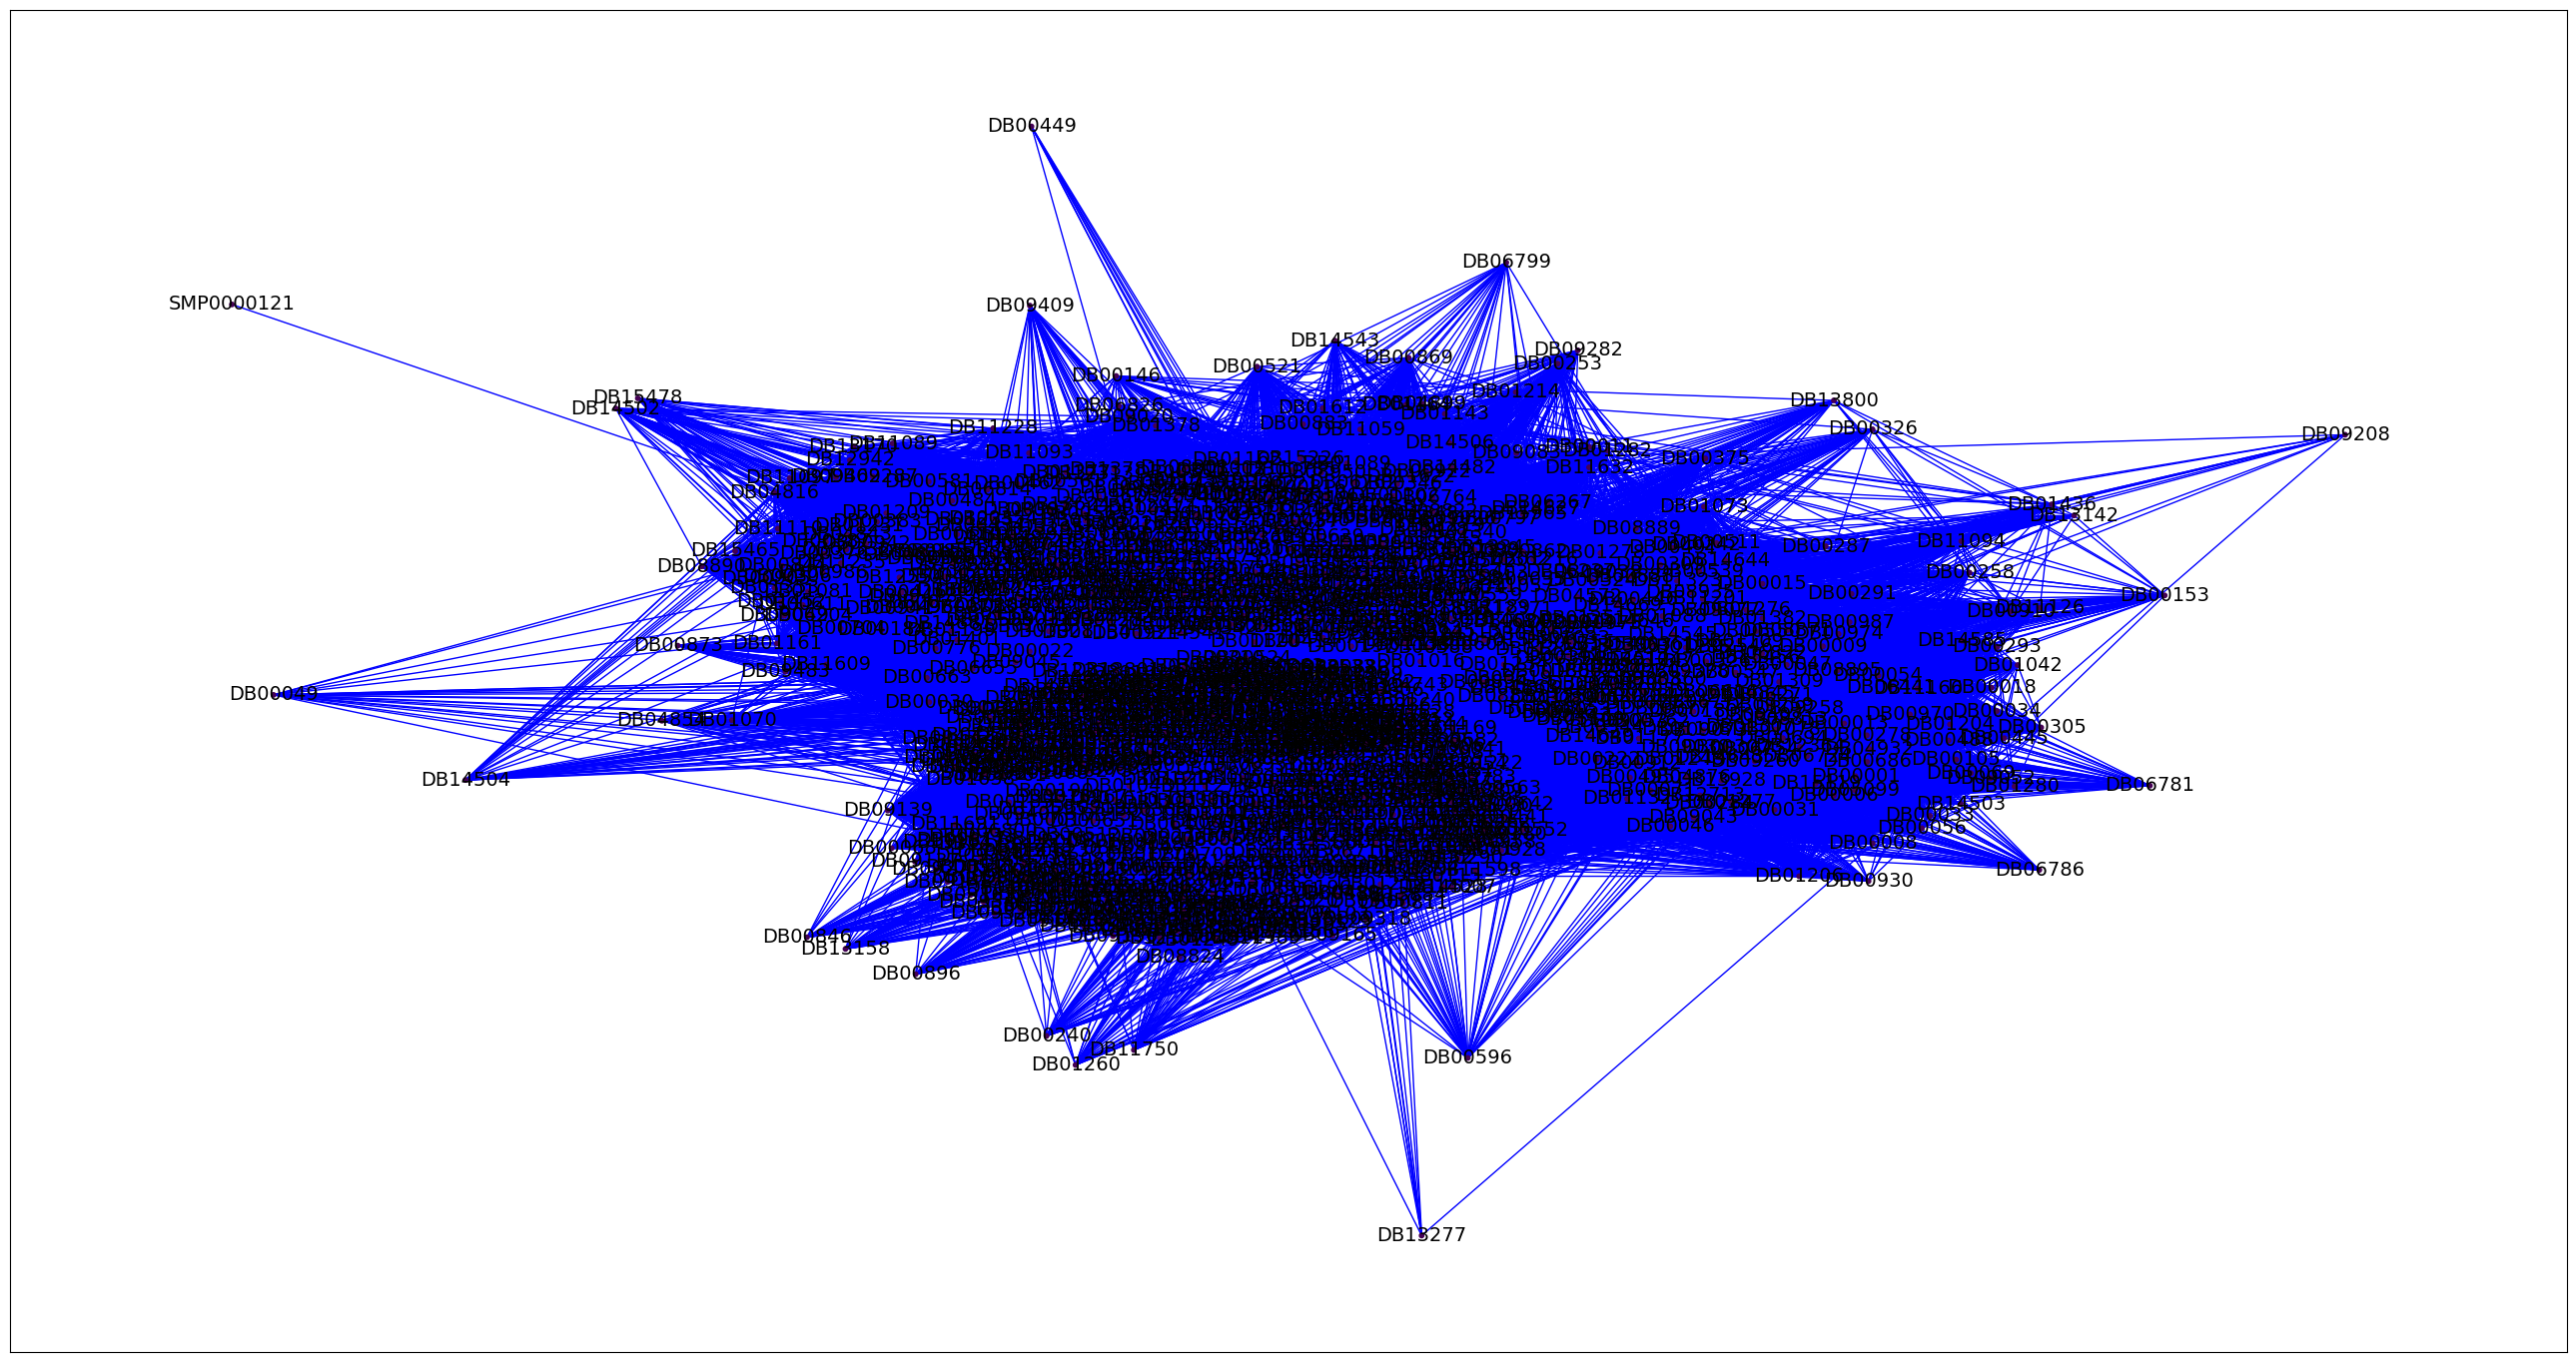

In [63]:
drawnodegraph(G, 'DB01021')